<a href="https://www.kaggle.com/concyclics/dog-vs-cat-classification-vgg-model?scriptVersionId=88634012" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dog vs Cat Classification
#### Author: Concyclics
### ***Upvote*** me please if you thought it's helpful

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

## 1. Load datas

In [2]:
split=0.4
seed=19260817
batch_size=100
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    '../input/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training',
)
val_ds = keras.utils.image_dataset_from_directory(
    '../input/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation',
)


Found 25000 files belonging to 2 classes.
Using 15000 files for training.


2022-02-24 10:12:38.513707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 10:12:38.604394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 10:12:38.605242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 10:12:38.608561: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 25000 files belonging to 2 classes.
Using 10000 files for validation.


### 1.1 visualize some images

2022-02-24 10:12:45.508675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


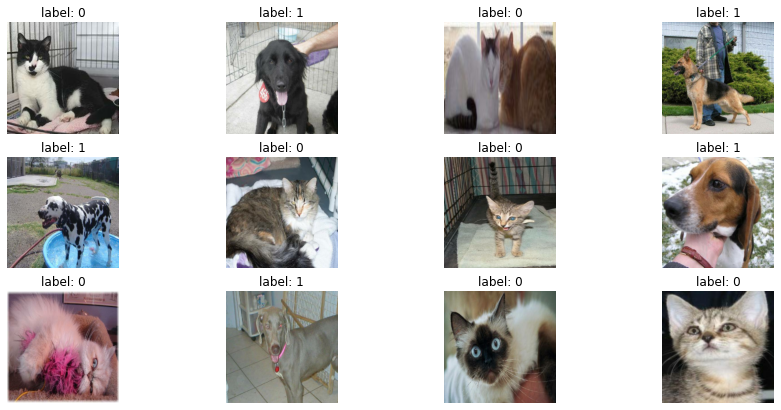

In [3]:
fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4,i+1)
        plt.imshow(img.numpy()[i]/255)
        plt.axis("off")
        plt.title("label: "+str(label.numpy()[i]))
        #rint("label:", label.numpy()[i])
plt.show()

## 2. VGG model

### 2.1 augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        #layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.14,0.14),
        layers.RandomZoom(0.2),
        #layers.RandomContrast(0.2),
    ]
)

### 2.2 vgg16 model

In [5]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

#conv_base.trainable = True
conv_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   

In [6]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0     

### 2.3 callback

In [7]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),
    
            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=3)
]

### 2.4 train the model

In [8]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=CB
    )
model = keras.models.load_model("fine_tuning.keras")
print('train finished')

Epoch 1/10


2022-02-24 10:12:54.802650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


150/150 [==============================] - 105s 600ms/step - loss: 132.6146 - accuracy: 0.8483 - val_loss: 4.1194 - val_accuracy: 0.9697
Epoch 2/10
150/150 [==============================] - 66s 435ms/step - loss: 10.4516 - accuracy: 0.8987 - val_loss: 4.5614 - val_accuracy: 0.9642
Epoch 3/10
150/150 [==============================] - 63s 411ms/step - loss: 6.4582 - accuracy: 0.9047 - val_loss: 1.0027 - val_accuracy: 0.9797
Epoch 4/10
150/150 [==============================] - 66s 435ms/step - loss: 8.4262 - accuracy: 0.9083 - val_loss: 2.5786 - val_accuracy: 0.9816
Epoch 5/10
150/150 [==============================] - 67s 437ms/step - loss: 6.6023 - accuracy: 0.9159 - val_loss: 2.0123 - val_accuracy: 0.9799
Epoch 6/10
150/150 [==============================] - 57s 374ms/step - loss: 8.9104 - accuracy: 0.9183 - val_loss: 3.5981 - val_accuracy: 0.9789
train finished


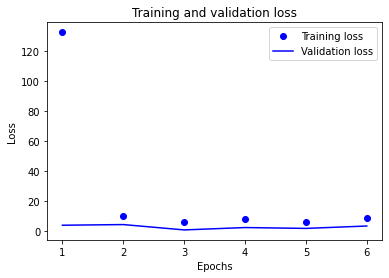

In [9]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
print("This is the number of trainable weights "
      "before activating:", len(model.trainable_weights))

model.trainable = True

print("This is the number of trainable weights "
      "after activating:", len(model.trainable_weights))

This is the number of trainable weights before activating: 6
This is the number of trainable weights after activating: 32


In [11]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=CB
    )
model = keras.models.load_model("fine_tuning.keras")
print('train finished')

Epoch 1/10
150/150 [==============================] - 67s 435ms/step - loss: 8.0564 - accuracy: 0.9145 - val_loss: 5.3702 - val_accuracy: 0.9742
Epoch 2/10
150/150 [==============================] - 67s 436ms/step - loss: 7.1155 - accuracy: 0.9164 - val_loss: 2.4568 - val_accuracy: 0.9654
Epoch 3/10
150/150 [==============================] - 63s 410ms/step - loss: 8.8666 - accuracy: 0.9169 - val_loss: 1.4579 - val_accuracy: 0.9840
Epoch 4/10
150/150 [==============================] - 67s 439ms/step - loss: 8.7827 - accuracy: 0.9191 - val_loss: 3.1384 - val_accuracy: 0.9828
Epoch 5/10
150/150 [==============================] - 66s 434ms/step - loss: 7.6073 - accuracy: 0.9221 - val_loss: 1.4857 - val_accuracy: 0.9810
Epoch 6/10
150/150 [==============================] - 67s 438ms/step - loss: 7.8277 - accuracy: 0.9255 - val_loss: 1.4218 - val_accuracy: 0.9808
Epoch 7/10
150/150 [==============================] - 63s 414ms/step - loss: 9.0692 - accuracy: 0.9229 - val_loss: 4.7214 - val_ac

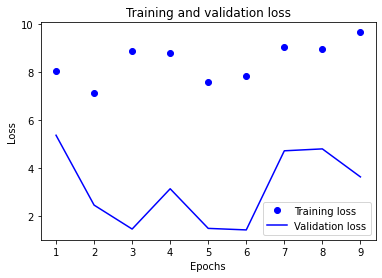

In [12]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 3. Prediction

### 3.1 prepare testing data

In [13]:
import os
test_filenames = os.listdir("../input/dog-vs-cat-classification/test/test")
test_df = pd.DataFrame({
    'id': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

8000

In [14]:
from keras.preprocessing.image import ImageDataGenerator, load_img
test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/dog-vs-cat-classification/test/test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 8000 validated image filenames.


### 3.2 predict

In [15]:
predict = model.predict(test_generator)
test_df['labels'] = np.argmax(predict, axis=-1)

In [16]:
test_df

,id,labels
0,005463.jpg,1
1,000304.jpg,1
2,001940.jpg,1
3,007289.jpg,1
4,005491.jpg,0
...,...,...
7995,004881.jpg,0
7996,003638.jpg,0
7997,007845.jpg,0
7998,007882.jpg,1


### 3.3 submit

In [17]:
test_df.set_index('id')
test_df.to_csv('submission.csv',index=False)